In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# %%
# import
# model
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd  # data processing
import numpy as np  # linear algebra
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

# score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
import joblib  # new lib
# visualize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# For Building the model
# Nature langue
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

--------RAW DATA-----------
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
--------Map tweet categories--------
                                          clean_text  category
0  when modi promised “minimum government maximum...      True
1  talk all the nonsense and continue all the dra...     False
2  what did just say vote for modi  welcome bjp t...     False
3  asking his supporters prefix chowkidar their n...     False
4  answer who among these the most powerful world...     False


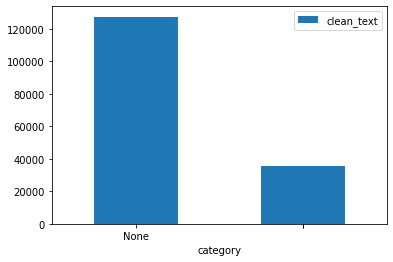

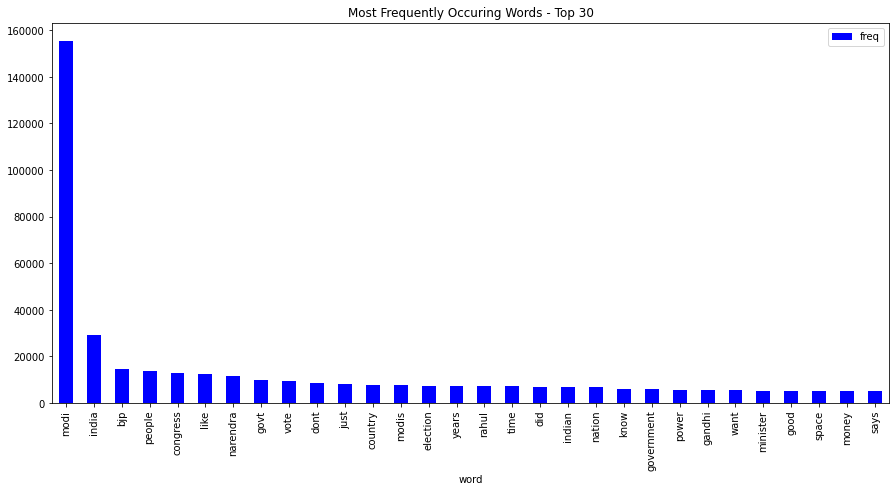

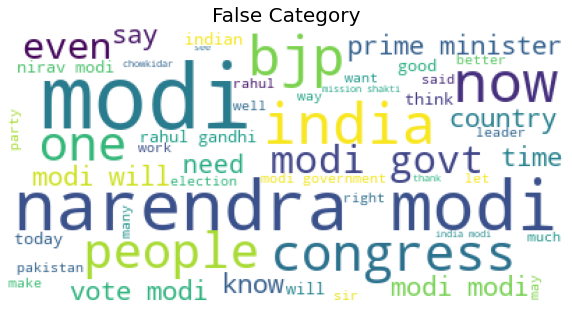

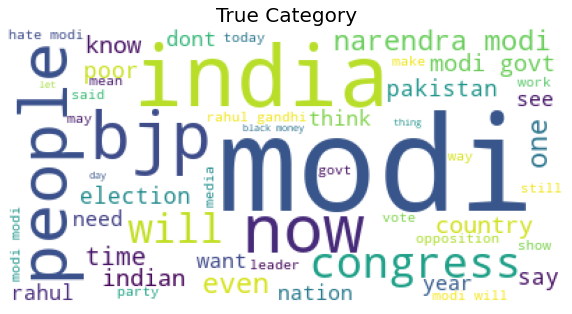

In [4]:

# Load Tweet dataset
df = pd.read_csv(
    '/content/gdrive/MyDrive/top1_textMining/Twitter_Data.csv')
# Output first five rows
print("--------RAW DATA-----------")
print(df.head())
# %%
# Map tweet categories
df['category'] = df['category'] == -1   # true: negative,

# Output first five rows
print("--------Map tweet categories--------")
print(df.head())

# %%
# overall
df.isnull().sum()
df.dropna(axis=0, inplace=True)
df['clean_text'].astype(str)
# %%
# The distribution of sentiments

df.groupby('category').count().plot(kind='bar')

#%%
# Calculate tweet lengths
tweet_len = pd.Series([len(str(tweet).split()) for tweet in df['clean_text']])
# The distribution of tweet text lengths
tweet_len.plot(kind='box')

#%%
# Most Frequently Occuring Words
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df['clean_text'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
# sorted by count
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar',
                        figsize=(15, 7), color='blue')
plt.title("Most Frequently Occuring Words - Top 30")

# %%
# Visualize common words
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: True False
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Category'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
# Positive tweet words
wordcount_gen(df, False)
     
# Negative tweet words
wordcount_gen(df, True)


In [ ]:
# %%
# Preprocessing data
# store and load


def store_model(model, model_name="model"):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "":
        model_name = type(model).__name__
    joblib.dump(model, '/content/gdrive/MyDrive/top1_textMining/stored_twitter/' + model_name)


def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('/content/gdrive/MyDrive/top1_textMining/stored_twitter/' + model_name)
    # print(model)
    return model


# define FormatText


class FormatText(BaseEstimator, TransformerMixin):
    def tweet_to_words(self, tweet):
        ''' Convert tweet text into a sequence of words '''

        # convert to lowercase
        text = tweet.lower()
        # remove non letters
        text = re.sub(r"[^a-zA-Z0-9]", " ", text)
        # tokenize
        words = text.split()
        # remove stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        # apply stemming
        words = [PorterStemmer().stem(w) for w in words]
        # join list to string
        text = ' '.join(words)
        return text

    def __init__(self):
        pass

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe['clean_text'].apply(self.tweet_to_words)


# %%
# split data
train_set, test_set = train_test_split(df, test_size=0.17, random_state=42)
print('\n____________________________________ Split training an test set ____________________________________')
print(len(train_set), "train +", len(test_set), "test examples")
print(train_set.head(4))

# Separate labels from data, since we do not process label values
train_set_labels = train_set["category"].copy()
train_set = train_set.drop(columns="category")
test_set_labels = test_set["category"].copy()
test_set = test_set.drop(columns="category")



____________________________________ Split training an test set ____________________________________
135270 train + 27706 test examples
                                               clean_text  category
100825  people shouldn’ scam here and really should vo...     False
77192   your father used the nasty language for hindus...      True
37148                               modi thats your karma     False
96907   and are only dong hate modi campaign since lat...      True


In [ ]:

# Making pipeline preprocessing
new_training = 0
if new_training:
    pipeline = Pipeline([
        ('format', FormatText()),
        ('TfidfVectorizer', TfidfVectorizer(
            lowercase=True, stop_words='english', max_features=5000))
    ])
    pipeline.fit(train_set)
    store_model(pipeline, 'PipelinePre')
else:
    pipeline = load_model('PipelinePre')

# processed_train_set_val
if new_training:
    processed_set_val = pipeline.transform(train_set).toarray()
    store_model(processed_set_val, 'processed_train_set_val')
else:
    processed_set_val = load_model('processed_train_set_val')
    print("shape processed data:" +  str(processed_set_val.shape))



shape processed data:(135270, 5000)


In [ ]:
# %%
# Train model
# score model

def print_score(label, prediction):
    clf_report = pd.DataFrame(classification_report(
        label, prediction, output_dict=True))
    print("Train Result:\n================================================")
    print(
        f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Classification Report:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")



In [ ]:
# %%
# Try Stochastic Gradient Descent (SGD) classifier
if new_training:
    # set random_state to reproduce the result
    model = SGDClassifier(random_state=42)
    model.fit(processed_set_val, train_set_labels)
    store_model(model, "SGDClassifier")

else:
    model = load_model("SGDClassifier")
print('\n____________________________________ SGD ____________________________________')
if True:
    # Predict a sample:
    prediction = model.predict(processed_set_val)
    print_score(train_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(train_set_labels[:9]))


____________________________________ SGD ____________________________________
Train Result:
Accuracy Score: 85.57%
_______________________________________________
Classification Report:
                   False          True  accuracy      macro avg   weighted avg
precision       0.854537      0.866134  0.855696       0.860335       0.857059
recall          0.982900      0.398049  0.855696       0.690475       0.855696
f1-score        0.914235      0.545433  0.855696       0.729834       0.834021
support    105849.000000  29421.000000  0.855696  135270.000000  135270.000000
_______________________________________________
Confusion Matrix: 
 [[104039   1810]
 [ 17710  11711]]

Predictions:  [False False False  True  True False False False False]
Labels:       [False, True, False, True, True, False, False, True, True]


In [ ]:
# %%
# Try Logistic Regression
if new_training == True:
    # set random_state to reproduce the result
    model = LogisticRegression(random_state=42)
    model.fit(processed_set_val, train_set_labels)
    store_model(model, "LogisticRegression")
else:
    model = load_model("LogisticRegression")
print('\n____________________________________ LogisticRegression ____________________________________')
if True:
    # Predict a sample:
    prediction = model.predict(processed_set_val)
    print_score(train_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(train_set_labels[:9]))



____________________________________ LogisticRegression ____________________________________
Train Result:
Accuracy Score: 89.39%
_______________________________________________
Classification Report:
                   False          True  accuracy      macro avg   weighted avg
precision       0.901612      0.852908  0.893923       0.877260       0.891019
recall          0.970326      0.619048  0.893923       0.794687       0.893923
f1-score        0.934708      0.717400  0.893923       0.826054       0.887444
support    105849.000000  29421.000000  0.893923  135270.000000  135270.000000
_______________________________________________
Confusion Matrix: 
 [[102708   3141]
 [ 11208  18213]]

Predictions:  [False False False  True  True False False  True False]
Labels:       [False, True, False, True, True, False, False, True, True]


In [ ]:
# %%
# try Ramdom Forest Classifier
if new_training == True:
    # set random_state to reproduce the result
    model = RandomForestClassifier(
        random_state=42, max_depth=4, n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
    model.fit(processed_set_val, train_set_labels)
    store_model(model, "RandomForestClassifier")
else:
    model = load_model("RandomForestClassifier")
print('\n____________________________________ RandomForestClassifier ____________________________________')
if True:
    # Predict a sample:
    prediction = model.predict(processed_set_val)
    print_score(train_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(train_set_labels[:9]))


____________________________________ RandomForestClassifier ____________________________________
Train Result:
Accuracy Score: 78.25%
_______________________________________________
Classification Report:
                   False     True  accuracy      macro avg   weighted avg
precision       0.782502      0.0  0.782502       0.391251       0.612309
recall          1.000000      0.0  0.782502       0.500000       0.782502
f1-score        0.877981      0.0  0.782502       0.438991       0.687022
support    105849.000000  29421.0  0.782502  135270.000000  135270.000000
_______________________________________________
Confusion Matrix: 
 [[105849      0]
 [ 29421      0]]

Predictions:  [False False False False False False False False False]
Labels:       [False, True, False, True, True, False, False, True, True]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# %%
# try Decision Tree Classifier
if new_training == True:
    # set random_state to reproduce the result
    model = DecisionTreeClassifier(random_state=42)
    model.fit(processed_set_val, train_set_labels)
    store_model(model, "DecisionTreeClassifier")
else:
    model = load_model("DecisionTreeClassifier")
print('\n____________________________________ DecisionTreeClassifier ____________________________________')
if True:
    # Predict a sample:
    prediction = model.predict(processed_set_val)
    print_score(train_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(train_set_labels[:9]))


____________________________________ DecisionTreeClassifier ____________________________________
Train Result:
Accuracy Score: 99.93%
_______________________________________________
Classification Report:
                   False          True  accuracy      macro avg  weighted avg
precision       0.999198      0.999761   0.99932       0.999480       0.99932
recall          0.999934      0.997111   0.99932       0.998522       0.99932
f1-score        0.999566      0.998434   0.99932       0.999000       0.99932
support    105849.000000  29421.000000   0.99932  135270.000000  135270.00000
_______________________________________________
Confusion Matrix: 
 [[105842      7]
 [    85  29336]]

Predictions:  [False  True False  True  True False False  True  True]
Labels:       [False, True, False, True, True, False, False, True, True]


In [ ]:
# Try Linear SVC
if new_training == True:
    # set random_state to reproduce the result
    model = LinearSVC(random_state=42, C=1, loss='hinge')
    model.fit(processed_set_val, train_set_labels)
    store_model(model, "LinearSVC")
else:
    model = load_model("LinearSVC")
print('\n____________________________________ LinearSVC ____________________________________')

if True:
    # Predict a sample:
    prediction = model.predict(processed_set_val)
    print_score(train_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(train_set_labels[:9]))


____________________________________ LinearSVC ____________________________________
Train Result:
Accuracy Score: 90.50%
_______________________________________________
Classification Report:
                   False          True  accuracy      macro avg   weighted avg
precision       0.919594      0.838621  0.904953       0.879107       0.901982
recall          0.962711      0.697155  0.904953       0.829933       0.904953
f1-score        0.940658      0.761373  0.904953       0.851016       0.901664
support    105849.000000  29421.000000  0.904953  135270.000000  135270.000000
_______________________________________________
Confusion Matrix: 
 [[101902   3947]
 [  8910  20511]]

Predictions:  [False False False  True  True False False  True False]
Labels:       [False, True, False, True, True, False, False, True, True]


In [ ]:
# Try MultinomialNB

new_training=1
if new_training == True:
    # set random_state to reproduce the result
    model = MultinomialNB()
    model.fit(processed_set_val, train_set_labels)
    store_model(model, "MultinomialNB")
else:
    model = load_model("MultinomialNB")
print('\n____________________________________ MultinomialNB ____________________________________')
if True:
    # Predict a sample:
    prediction = model.predict(processed_set_val)
    print_score(train_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(train_set_labels[:9]))


____________________________________ MultinomialNB ____________________________________
Train Result:
Accuracy Score: 81.60%
_______________________________________________
Classification Report:
                   False          True  accuracy      macro avg   weighted avg
precision       0.811267      0.933576   0.81599       0.872421       0.837869
recall          0.996722      0.165766   0.81599       0.581244       0.815990
f1-score        0.894483      0.281541   0.81599       0.588012       0.761169
support    105849.000000  29421.000000   0.81599  135270.000000  135270.000000
_______________________________________________
Confusion Matrix: 
 [[105502    347]
 [ 24544   4877]]

Predictions:  [False False False False False False False False False]
Labels:       [False, True, False, True, True, False, False, True, True]


In [ ]:

# %%
# Test Data
new_training=0
# preprocessing test data
if new_training:
    processed_set_val = pipeline.transform(test_set).toarray()
    store_model(processed_set_val, 'processed_test_set_val')
else:
    processed_set_val = load_model('processed_test_set_val')

print(processed_set_val.shape)

(27706, 5000)


In [ ]:
if True:
    # %%
    # SGDClassifier in test data
    model = load_model("SGDClassifier")
    print('\n____________________________________ SGD ____________________________________')
    prediction = model.predict(processed_set_val)
    print_score(test_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(test_set_labels[:9]))

    # %%
    # LogisticRegression in test data
    model = load_model("LogisticRegression")
    print('\n____________________________________ LogisticRegression ____________________________________')
    prediction = model.predict(processed_set_val)
    print_score(test_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(test_set_labels[:9]))
    # %%
    # RandomForestClassifier in test data
    model = load_model("RandomForestClassifier")
    print('\n____________________________________ RandomForestClassifier ____________________________________')
    prediction = model.predict(processed_set_val)
    print_score(test_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(test_set_labels[:9]))
    # %%
    # DecisionTreeClassifier
    model = load_model("DecisionTreeClassifier")
    print('\n____________________________________ DecisionTreeClassifier ____________________________________')
    prediction = model.predict(processed_set_val)
    print_score(test_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(test_set_labels[:9]))

    # %%
    # LinearSVC
    model = load_model("LinearSVC")
    print('\n____________________________________ LinearSVC ____________________________________')
    prediction = model.predict(processed_set_val)
    print_score(test_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(test_set_labels[:9]))
    
    # %%
    # MultinomialNB
    model = load_model("MultinomialNB")
    print('\n____________________________________ MultinomialNB ____________________________________')
    prediction = model.predict(processed_set_val)
    print_score(test_set_labels, prediction)
    print("Predictions: ", prediction[:9])
    print("Labels:      ", list(test_set_labels[:9]))



____________________________________ SGD ____________________________________
Train Result:
Accuracy Score: 85.22%
_______________________________________________
Classification Report:
                  False         True  accuracy     macro avg  weighted avg
precision      0.850727     0.865688  0.852198      0.858207      0.854014
recall         0.983070     0.387484  0.852198      0.685277      0.852198
f1-score       0.912123     0.535346  0.852198      0.723734      0.829331
support    21618.000000  6088.000000  0.852198  27706.000000  27706.000000
_______________________________________________
Confusion Matrix: 
 [[21252   366]
 [ 3729  2359]]

Predictions:  [False False False False False False False False False]
Labels:       [True, False, False, False, False, False, False, False, False]

____________________________________ LogisticRegression ____________________________________
Train Result:
Accuracy Score: 88.36%
_______________________________________________
Classificati

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Result:
Accuracy Score: 78.03%
_______________________________________________
Classification Report:
                  False    True  accuracy     macro avg  weighted avg
precision      0.780264     0.0  0.780264      0.390132      0.608812
recall         1.000000     0.0  0.780264      0.500000      0.780264
f1-score       0.876571     0.0  0.780264      0.438286      0.683957
support    21618.000000  6088.0  0.780264  27706.000000  27706.000000
_______________________________________________
Confusion Matrix: 
 [[21618     0]
 [ 6088     0]]

Predictions:  [False False False False False False False False False]
Labels:       [True, False, False, False, False, False, False, False, False]

____________________________________ DecisionTreeClassifier ____________________________________
Train Result:
Accuracy Score: 84.51%
_______________________________________________
Classification Report:
                  False         True  accuracy     macro avg  weighted avg
precision     

# New Section